# Testing dimensionality reduction on FoooF features to describe brain state and transition dynamics

In [ ]:
import os
import numpy as np
import mne
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator
from mne.preprocessing import ICA
from mne.time_frequency import psd_array_welch
import pyxdf
from fooof import FOOOF
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import autoreject
from mne.preprocessing import ICA
from pyprep.prep_pipeline import PrepPipeline
from autoreject import AutoReject
from mne.preprocessing import compute_current_source_density
from fooof.analysis import get_band_peak_fm
from fooof.plts.spectra import plot_spectra

[[  1.33423485  -0.77578518  -4.32850324 ... -18.24585265 -21.2298683
  -14.84936941]
 [  0.99828802  -5.17583933 -10.23671394 ... -10.95429872 -14.1534491
  -10.90478706]
 [ -1.91052058  -4.60520828  -3.61084957 ... -14.2255921  -13.89697297
   -6.81327015]
 ...
 [ -1.53408299  -6.6318894   -6.93412676 ... -16.16532947 -16.64019224
  -11.68179864]
 [ -2.59360157  -6.61478819  -6.04939334 ... -14.56862235 -17.96090038
  -14.83981786]
 [ -3.95529507  -9.47602521  -9.29842538 ...  -8.7726851  -14.3947761
  -16.49501773]]
256.0
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
Creating RawArray with float64 data, n_channels=19, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Using qt as 2D backend.


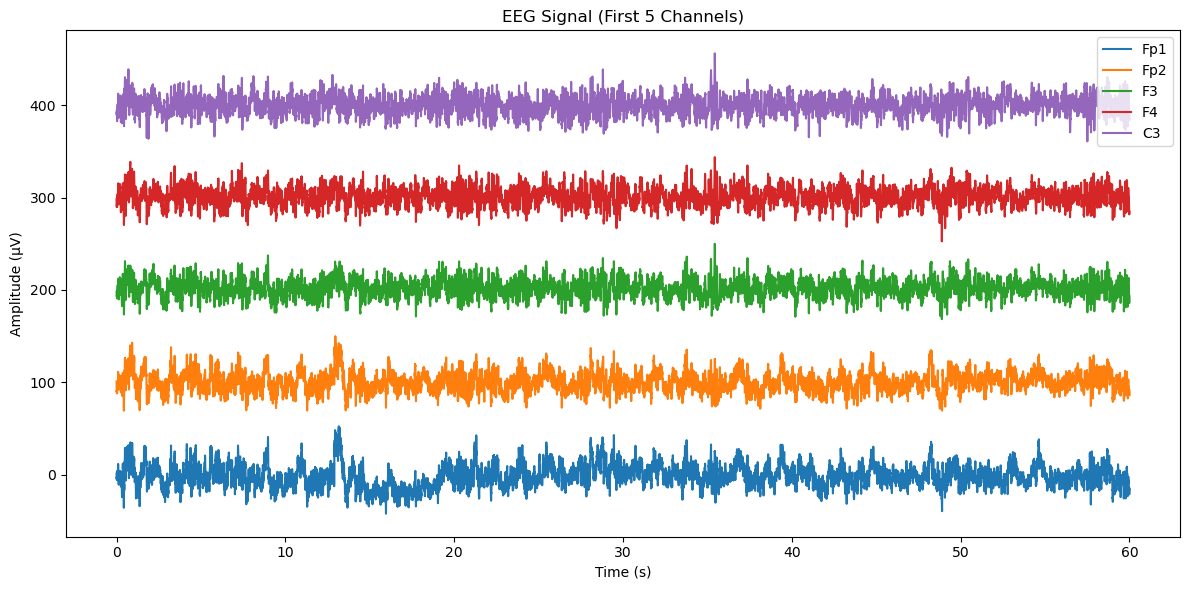

In [2]:
project_directory = os.path.dirname(os.path.dirname(os.path.abspath("umap_test")))


streams, header = pyxdf.load_xdf(os.path.join(project_directory, r"Data", r"Sub1_RS_EC.xdf"))
eeg_stream = streams[0]
RS_EC = np.array(eeg_stream['time_series']).T  # Transpose to channels x samples
sfreq = float(eeg_stream['info']['nominal_srate'][0])  # Sampling frequency
ch_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']  # Channel names
ch_names = [ch['label'][0] for ch in ch_names]

print(RS_EC)
print(sfreq)
print(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

raw_RS_EC = mne.io.RawArray(RS_EC, info)
raw_RS_EC.rename_channels({ch: ch.capitalize() for ch in raw_RS_EC.ch_names})
    # Add standard montage (10-20 system)
montage = mne.channels.make_standard_montage('standard_1020')
raw_RS_EC.set_montage(montage)
raw_RS_EC.plot(title="Resting State EEG (Eyes Closed)", scalings='auto')


data = raw_RS_EC.get_data()

time = np.arange(data.shape[1]) / sfreq

plt.figure(figsize=(12, 6))
for i in range(min(5, data.shape[0])):  # Plot up to 5 channels
    plt.plot(time, data[i] + i * 100, label=ch_names[i])  # Offset each channel for clarity
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("EEG Signal (First 5 Channels)")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def load_xdf_to_raw(xdf_file):
    # Load the XDF file using pyxdf
    streams, header = pyxdf.load_xdf(xdf_file)
    
    # Assume the first stream is the EEG data
    eeg_stream = streams[0]
    
    # Get EEG data and metadata
    data = np.array(eeg_stream['time_series']).T  # Transpose to channels x samples
    sfreq = float(eeg_stream['info']['nominal_srate'][0])  # Sampling frequency
    ch_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']  # Channel names
    ch_names = [ch['label'][0] for ch in ch_names]  
    
    # Create MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Normalize channel names (capitalize correctly for montage matching)
    raw.rename_channels({ch: ch.capitalize() for ch in raw.ch_names})
    
    # Add standard montage (10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    return raw

raw_rs = load_xdf_to_raw(os.path.join(project_directory, r"Data", r"Sub1_RS_EC.xdf"))
raw_breath = load_xdf_to_raw(os.path.join(project_directory, r"Data", r"Sub1_Breath_EC.xdf"))

print(raw_rs)
print(raw_breath)

2024-12-07 14:53:29,569 - pyxdf.pyxdf - INFO - Importing XDF file c:\Users\Jake\testing-learning2024\Data\Sub1_RS_EC.xdf...
2024-12-07 14:53:29,625 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2024-12-07 14:53:29,625 - pyxdf.pyxdf - INFO -   performing jitter removal...


Creating RawArray with float64 data, n_channels=19, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.


2024-12-07 14:53:29,633 - pyxdf.pyxdf - INFO - Importing XDF file c:\Users\Jake\testing-learning2024\Data\Sub1_Breath_EC.xdf...
2024-12-07 14:53:29,707 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2024-12-07 14:53:29,708 - pyxdf.pyxdf - INFO -   performing jitter removal...


Creating RawArray with float64 data, n_channels=19, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
<RawArray | 19 x 15360 (60.0 s), ~2.3 MB, data loaded>
<RawArray | 19 x 15360 (60.0 s), ~2.3 MB, data loaded>


## Preprocessing + Epoching

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


C:\Users\Jake\AppData\Local\Temp\ipykernel_17812\4006019907.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(eeg_data)


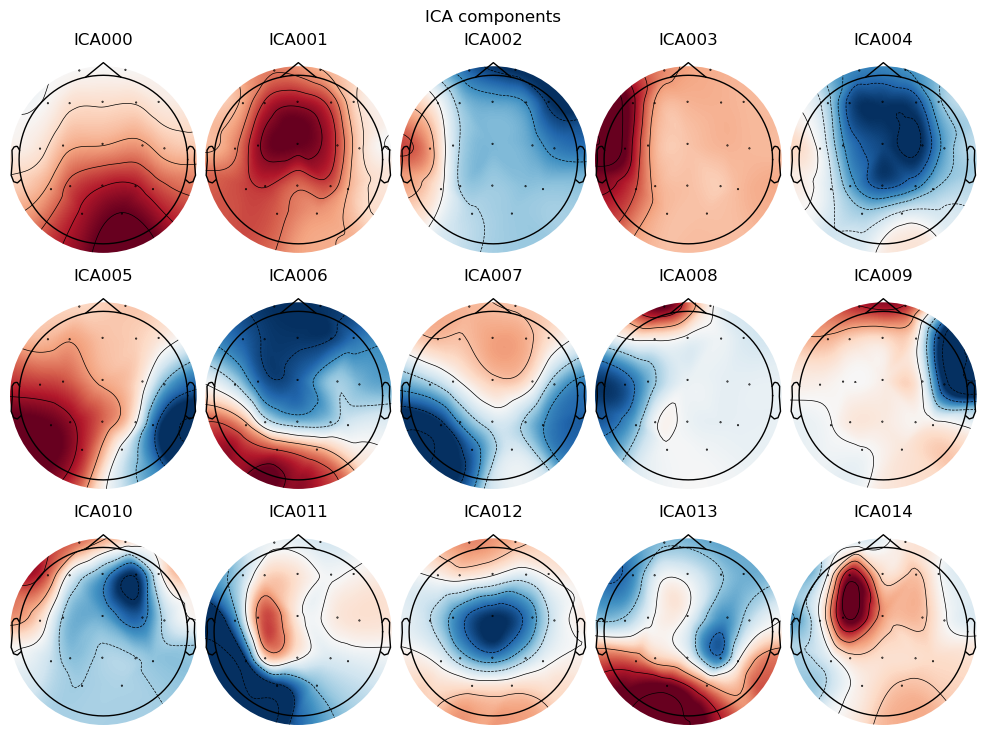

Effective window size : 8.000 (s)
Automatically identified muscle ICs: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Removed notch frequencies (Hz):
     60.00 :  209 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:19,491 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:20,295 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}
2024-12-07 14:58:20,306 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:21,046 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T3'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T3']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors


2024-12-07 14:58:21,089 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:21,805 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T3'], 'bad_by_correlation': ['C3'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T3']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors


2024-12-07 14:58:21,843 - pyprep.reference - INFO - Iterations: 3


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:22,568 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T3'], 'bad_by_correlation': ['C3'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T3']}
2024-12-07 14:58:22,568 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!
Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

1 by correlation: ['C3']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitted sphere radius:         95.4 mm
Origin head coordinates:      -1.0 15.6 45.4 mm
Origin device coordinates:    -1.0 15.6 45.4 mm
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


C:\Users\Jake\AppData\Local\Temp\ipykernel_17812\4006019907.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(eeg_data)


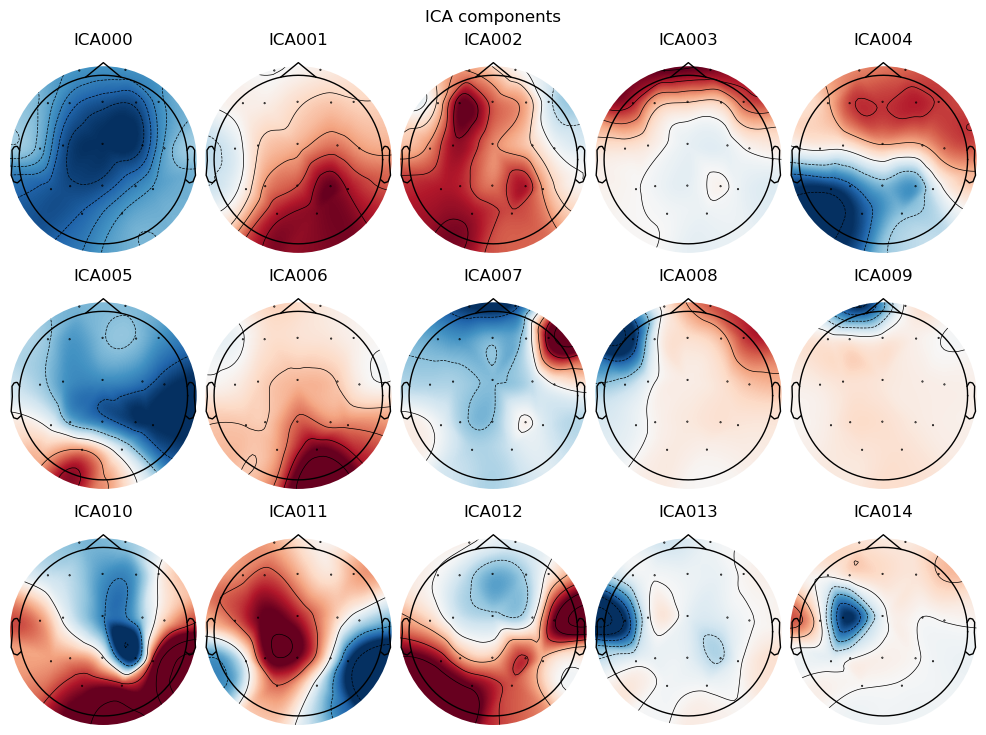

Effective window size : 8.000 (s)
Automatically identified muscle ICs: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Removed notch frequencies (Hz):
     60.00 :  209 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:31,266 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['F8'], 'bad_by_correlation': ['Fp1'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['F8', 'Fp1']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:32,074 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C3', 'T3', 'C4'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T3', 'C4']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors


2024-12-07 14:58:32,118 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:32,723 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C3', 'Fp1', 'T3', 'C4'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T3', 'Fp1', 'C4']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 4 sensors


2024-12-07 14:58:32,760 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!


2024-12-07 14:58:33,425 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C3', 'T3', 'Fp1', 'C4'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'C4', 'T3', 'Fp1']}
2024-12-07 14:58:33,425 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 4 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!
Found 3 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

3 by correlation: ['Fp1', 'C3', 'T3']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/11 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1024 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/15 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitted sphere radius:         95.4 mm
Origin head coordinates:      -1.0 15.6 45.4 mm
Origin device coordinates:    -1.0 15.6 45.4 mm


In [12]:
def prep_and_epoch(eeg_data):
    ica = ICA(n_components=15, random_state=42)
    ica.fit(eeg_data)
    ica.plot_components() 
    muscle_inds, scores = ica.find_bads_muscle(eeg_data, threshold=2.0)  # Detect muscle artifacts
    print(f"Automatically identified muscle ICs: {muscle_inds}")
    ica.exclude.extend(muscle_inds) # Identify artifact components manually
    ica.apply(eeg_data)

    montage = eeg_data.get_montage()
    eeg_data.load_data()

    prep_params = {
            "ref_chs": "eeg",  # Use all EEG channels for referencing
            "reref_chs": "eeg",  # Channels for final re-referencing
            "line_freqs": [60],  # Adjust for your location (50 Hz for Europe, 60 Hz for US)
        }
    prep = PrepPipeline(eeg_data, prep_params, montage)
    prep.fit()
    eeg_data.info["bads"] = prep.interpolated_channels  # Mark channels for interpolation
    eeg_data.interpolate_bads()

    def autoreject_epochs(eeg_data):
        # Create fixed-length epochs for autoreject to process
        epochs = mne.make_fixed_length_epochs(eeg_data, duration=4.0, overlap=0.0, preload=True)
        
        # Initialize and fit Autoreject
        ar = AutoReject(random_state=42, n_jobs=-1)
        epochs_clean = ar.fit_transform(epochs)
        
        return epochs_clean

    epoched = autoreject_epochs(eeg_data)

    def apply_csd(epochs):
        # Compute the CSD transformation to minimize volume conduction
        epochs_csd = compute_current_source_density(epochs)
        return epochs_csd

    epoched = apply_csd(epoched)
    return epoched

epochs_rs = prep_and_epoch(raw_rs)
epochs_breath = prep_and_epoch(raw_breath)


## Parameterizing the data of each epoch with FoooF (test)

In [21]:
from fooof import FOOOF
from fooof.analysis import get_band_peak_fm
from fooof.plts.spectra import plot_spectra
import numpy as np
import pandas as pd
from mne.time_frequency import psd_array_welch

# Define frequency bands
freq_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (13, 30),
    'gamma': (30, 40)
}

def parameterize_fooof_epochs(epochs, sfreq, fmin=1, fmax=40, max_peaks=4, min_peak_width=2):
    """
    Parameterize epochs using FOOOF to estimate aperiodic and periodic components.

    Parameters:
    - epochs: MNE Epochs object.
    - sfreq: Sampling frequency.
    - fmin: Minimum frequency for PSD.
    - fmax: Maximum frequency for PSD.
    - max_peaks: Maximum number of periodic peaks.
    - min_peak_width: Minimum peak width in Hz.

    Returns:
    - results: DataFrame with FOOOF parameters for each epoch.
    """
    results = []

    for epoch_idx, epoch_data in enumerate(epochs.get_data()):
        # Average across channels to simplify analysis (can be adapted for per-channel analysis)
        psd, freqs = psd_array_welch(epoch_data.mean(axis=0), sfreq, fmin=fmin, fmax=fmax, n_fft=256)

        # Initialize and fit FOOOF
        fm = FOOOF(
            peak_width_limits=(min_peak_width, 8),  # Fixed valid range for peak widths
            max_n_peaks=max_peaks, 
            verbose=False
        )
        fm.fit(freqs, psd)

        # Extract aperiodic parameters
        slope, offset = fm.get_params('aperiodic_params')

        # Extract band-specific peak information
        band_peaks = {band: get_band_peak_fm(fm, band_range) for band, band_range in freq_bands.items()}
        
        # Collect results for this epoch
        result = {
            'epoch_idx': epoch_idx,
            'aperiodic_slope': slope,
            'aperiodic_offset': offset,
        }

        # Add periodic metrics
        for band, peak in band_peaks.items():
            if len(peak) > 0:  # If a peak was found in this band
                result[f'{band}_cf'] = peak[0]  # Center frequency
                result[f'{band}_power'] = peak[1]  # Power
                result[f'{band}_bw'] = peak[2]  # Bandwidth
            else:  # If no peak was found
                result[f'{band}_cf'] = np.nan
                result[f'{band}_power'] = np.nan
                result[f'{band}_bw'] = np.nan

        results.append(result)

    # Return results as a DataFrame
    return pd.DataFrame(results)


# Example Usage
sfreq = epochs_rs.info['sfreq']  # Sampling frequency from epochs

# Parameterize Resting State Epochs
fooof_rest = parameterize_fooof_epochs(epochs_rs, sfreq)

# Parameterize Breathwork Epochs
fooof_breath = parameterize_fooof_epochs(epochs_breath, sfreq)

# Display results
print("Resting State FOOOF Results:")
print(fooof_rest)

print("\nBreathwork FOOOF Results:")
print(fooof_breath)


Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

### test

Creating RawArray with float64 data, n_channels=19, n_times=1024
    Range : 0 ... 1023 =      0.000 ...     3.996 secs
Ready.
Effective window size : 1.000 (s)


<Figure size 1000x600 with 0 Axes>

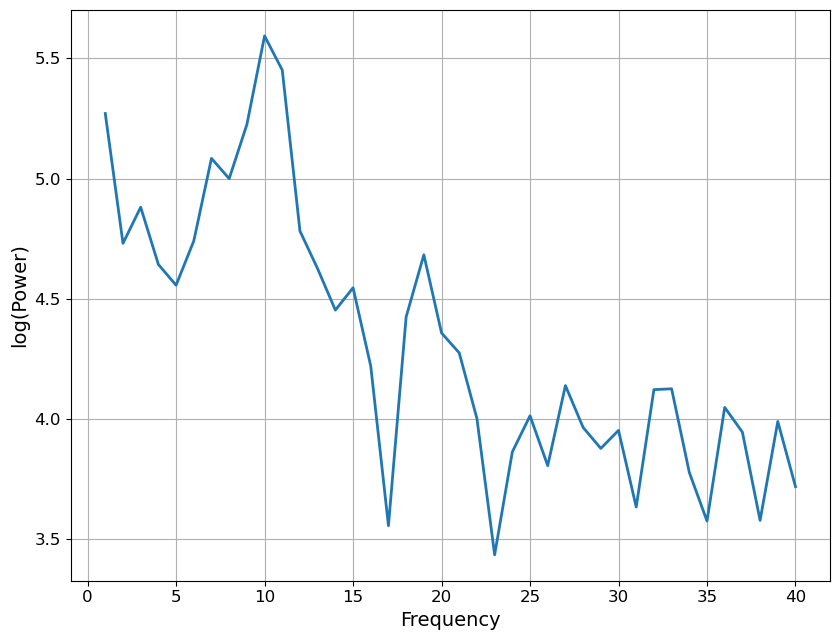

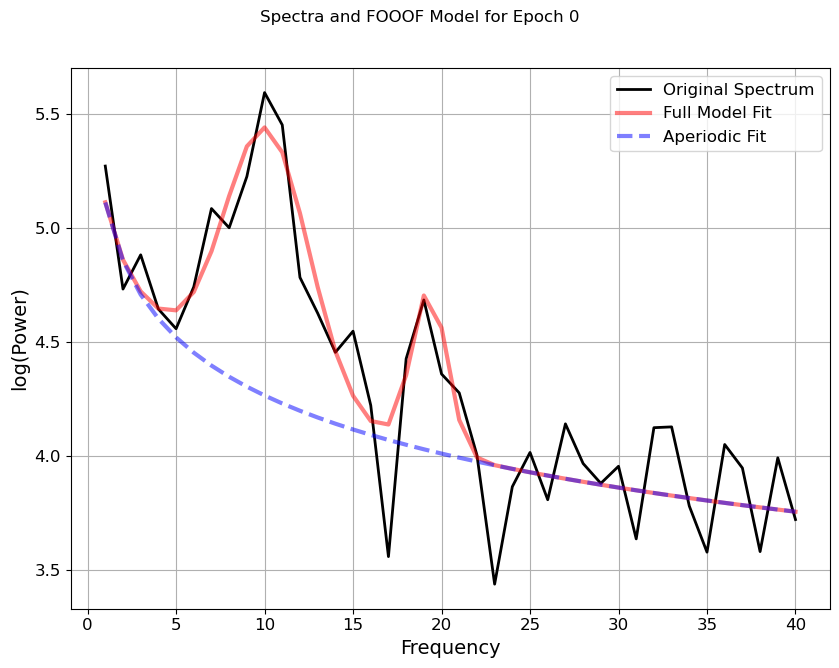

Creating RawArray with float64 data, n_channels=19, n_times=1024
    Range : 0 ... 1023 =      0.000 ...     3.996 secs
Ready.
Effective window size : 1.000 (s)


<Figure size 1000x600 with 0 Axes>

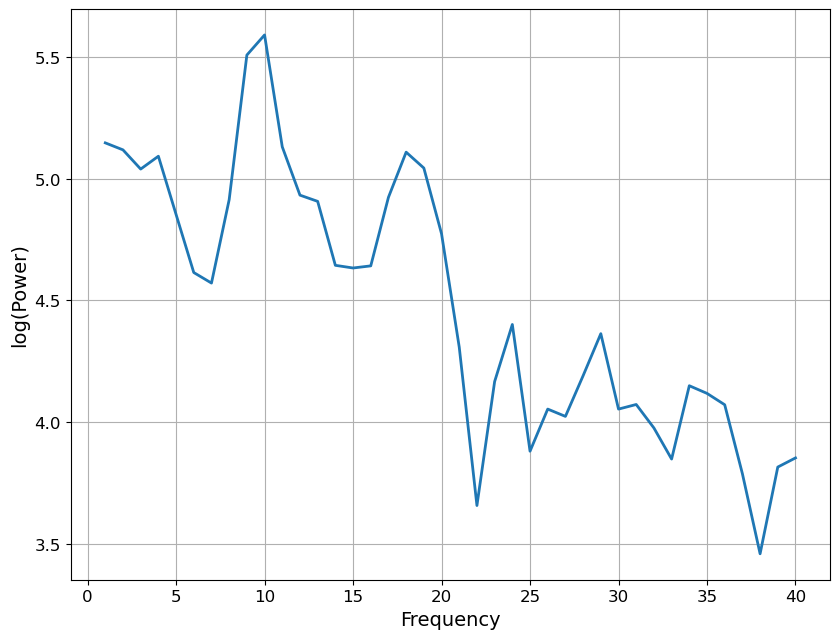

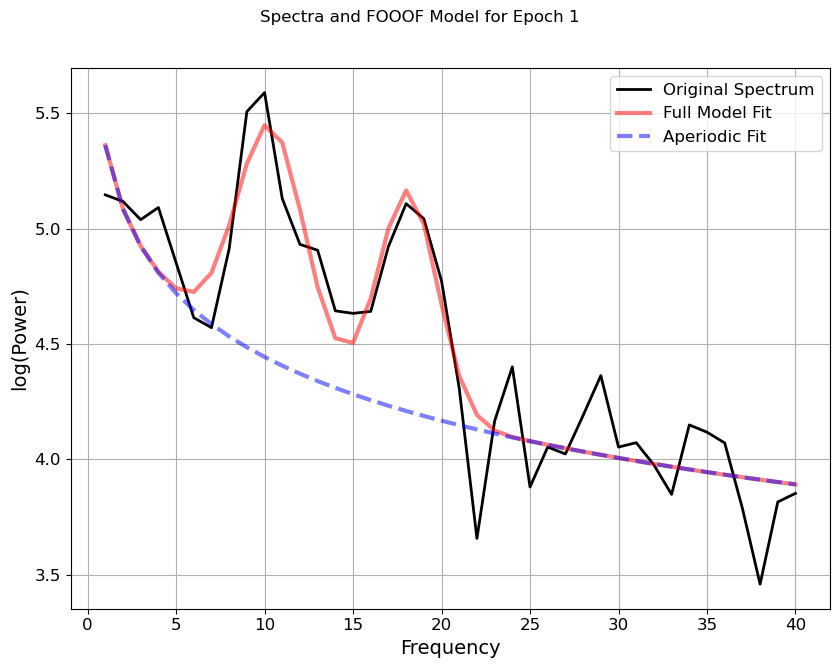

Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
from fooof.plts.spectra import plot_spectra
import matplotlib.pyplot as plt
import mne

# Function to plot raw data and FOOOF model for a specific epoch
def plot_epoch_with_spectra(epoch_data, epoch_idx, sfreq, fmin=1, fmax=40, n_fft=256, max_n_peaks=4):
    """
    Plot the raw data and spectra with FOOOF model for a given epoch.
    
    Parameters:
    - epoch_data: Epoch data (channels x time samples).
    - epoch_idx: Index of the epoch (for labeling).
    - sfreq: Sampling frequency of the data.
    - fmin: Minimum frequency for PSD.
    - fmax: Maximum frequency for PSD.
    - n_fft: FFT length for Welch's method.
    - max_n_peaks: Maximum number of peaks for FOOOF.
    """
    # Plot raw time-domain data
    raw = mne.io.RawArray(epoch_data, mne.create_info(
        ch_names=[f"Ch{i+1}" for i in range(epoch_data.shape[0])],
        sfreq=sfreq,
        ch_types='eeg'
    ))
    raw.plot(title=f'Raw Data for Epoch {epoch_idx}', scalings='auto')

    # Compute PSD
    psd, freqs = psd_array_welch(epoch_data.mean(axis=0), sfreq, fmin=fmin, fmax=fmax, n_fft=n_fft)

    # Initialize and fit FOOOF
    fm = FOOOF(max_n_peaks=max_n_peaks, verbose=False)
    fm.fit(freqs, psd)

    # Plot spectra and FOOOF model
    plt.figure(figsize=(10, 6))
    plot_spectra(freqs, psd, log_powers=True)
    fm.plot()
    plt.suptitle(f'Spectra and FOOOF Model for Epoch {epoch_idx}', y=1.02)
    plt.show()

# Example usage for two epochs
epoch_0_data = epochs_rs.get_data()[0]  # First epoch data
epoch_1_data = epochs_rs.get_data()[1]  # Second epoch data

# Plot for the first epoch
plot_epoch_with_spectra(epoch_0_data, epoch_idx=0, sfreq=sfreq)

# Plot for the second epoch
plot_epoch_with_spectra(epoch_1_data, epoch_idx=1, sfreq=sfreq)


### trying "time spent in a genuine alpha rythym" type analysis... Determine the proportion of the epoch duration where the alpha envelope exceeds the threshold.

Proportion of time in genuine alpha rhythm in epoch 0: 20.02%


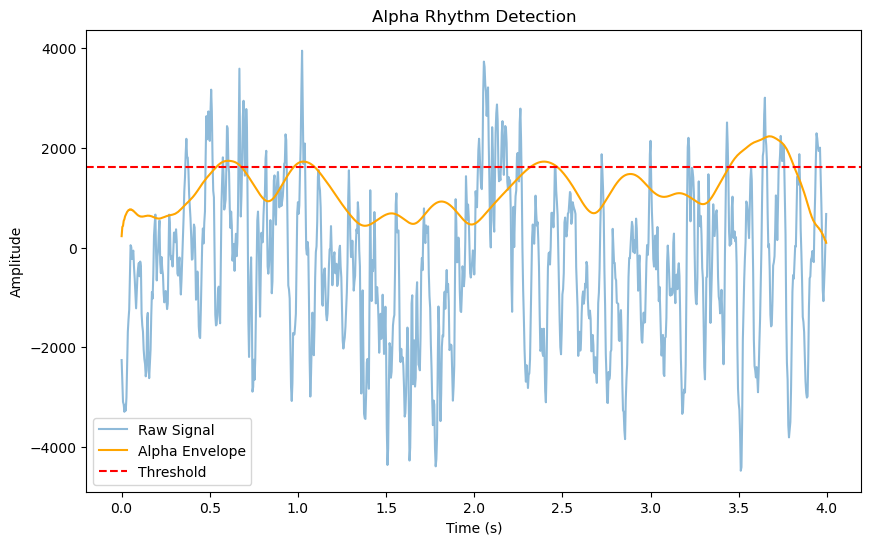

Proportion of time in genuine alpha rhythm in epoch 1: 18.26%


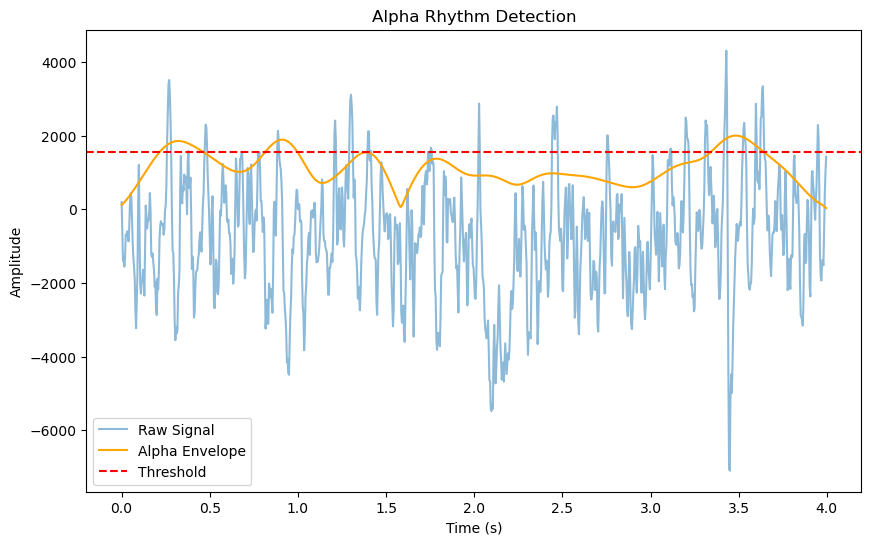

Proportion of time in genuine alpha rhythm in epoch 2: 13.96%


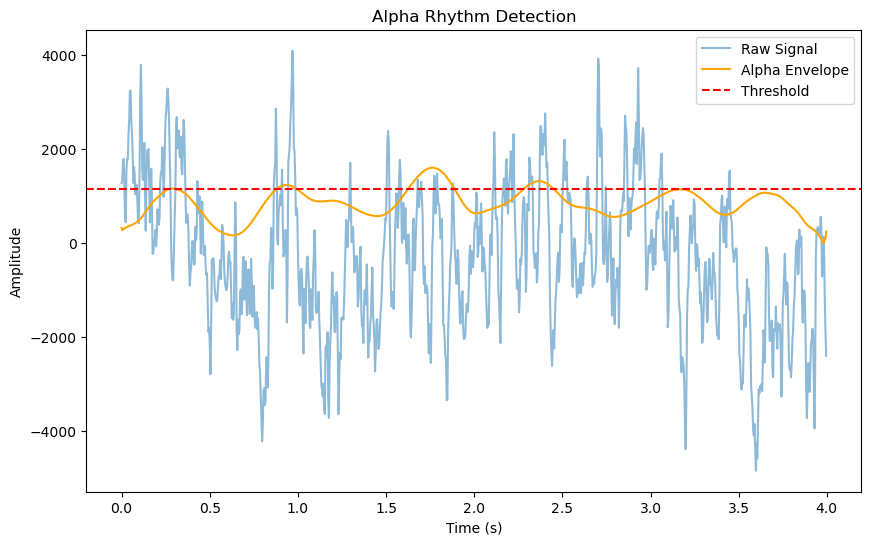

Proportion of time in genuine alpha rhythm in epoch 3: 21.88%


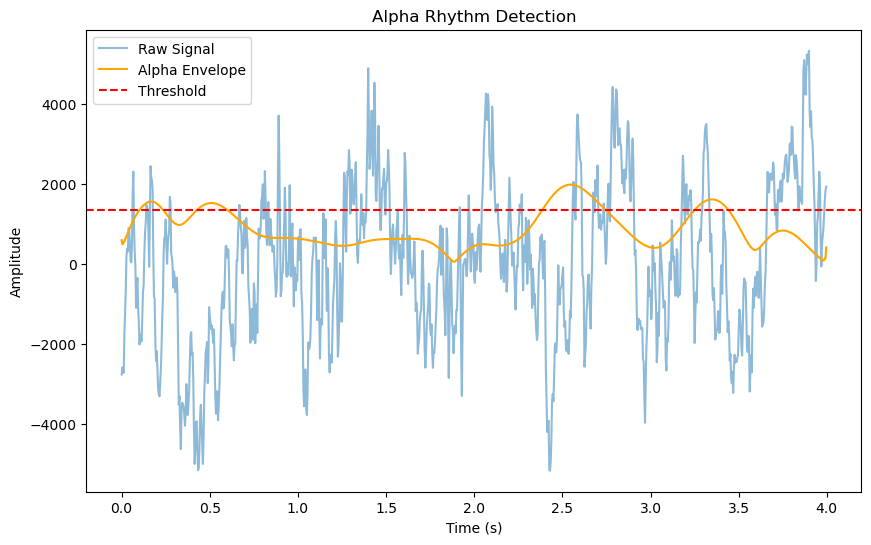

Proportion of time in genuine alpha rhythm in epoch 4: 20.61%


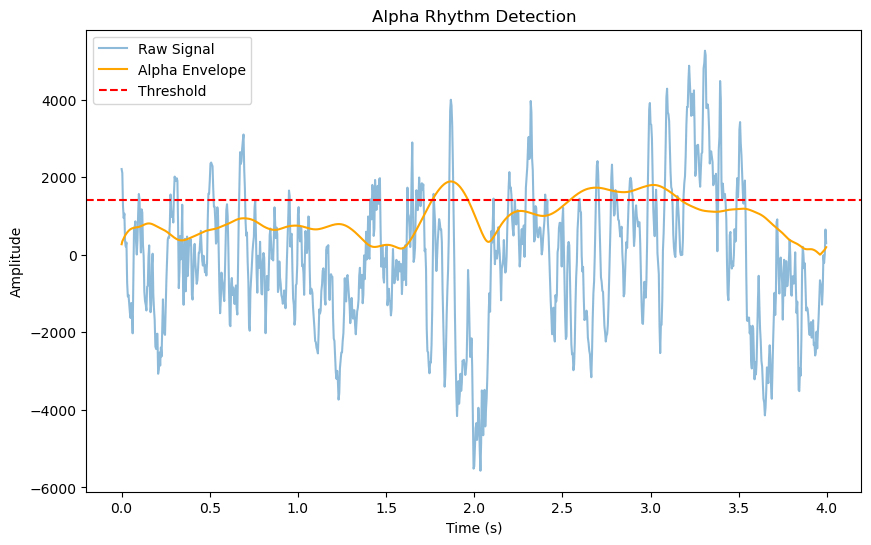

Proportion of time in genuine alpha rhythm in epoch 5: 15.43%


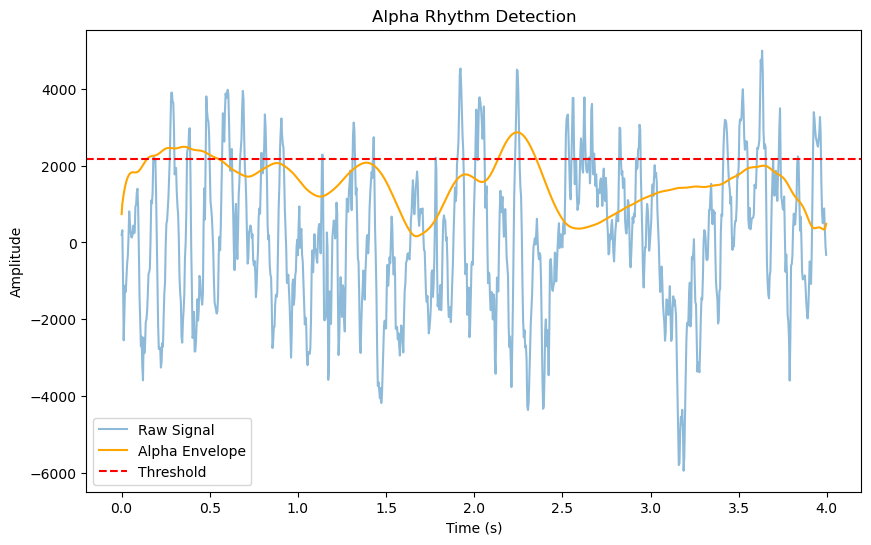

Proportion of time in genuine alpha rhythm in epoch 6: 24.90%


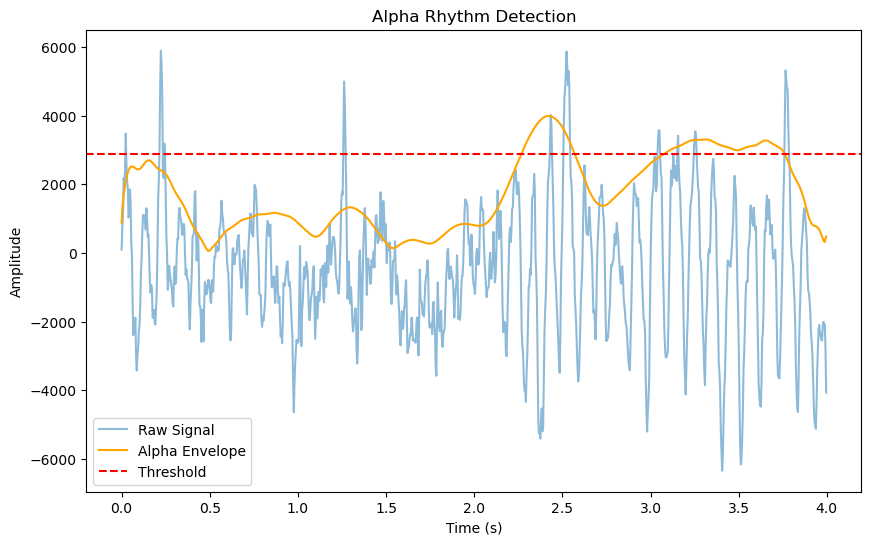

Proportion of time in genuine alpha rhythm in epoch 7: 12.01%


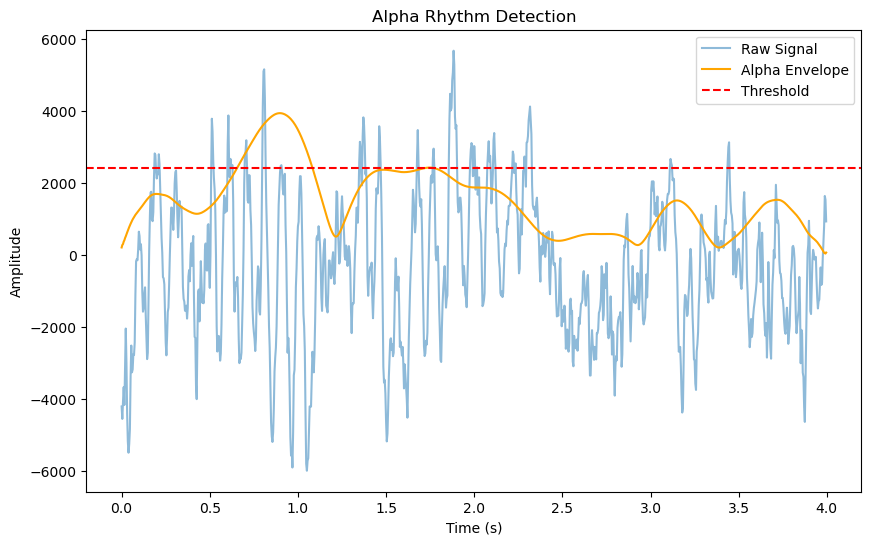

Proportion of time in genuine alpha rhythm in epoch 8: 20.31%


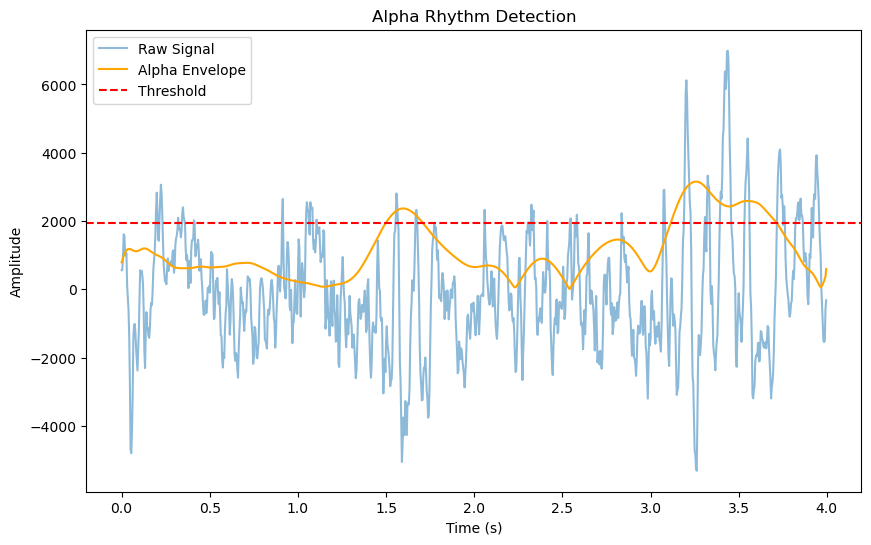

Proportion of time in genuine alpha rhythm in epoch 9: 9.96%


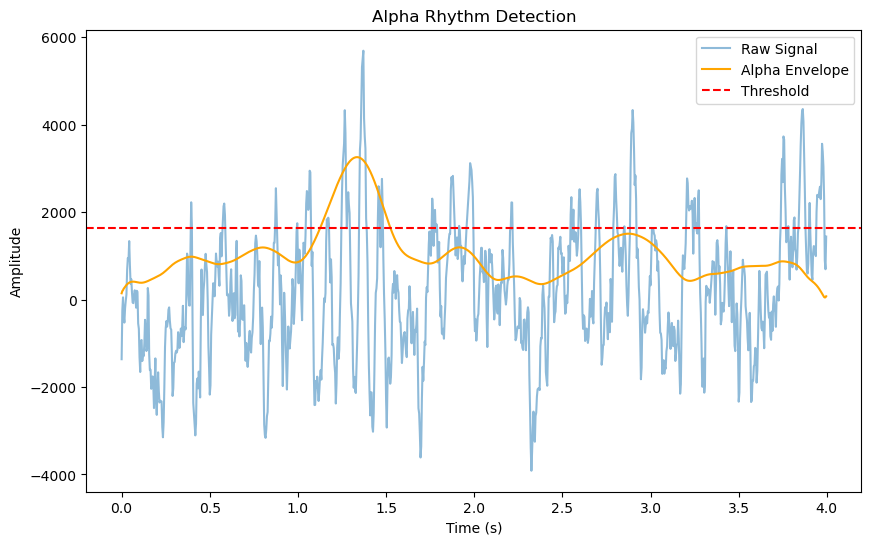

Proportion of time in genuine alpha rhythm in epoch 10: 14.75%


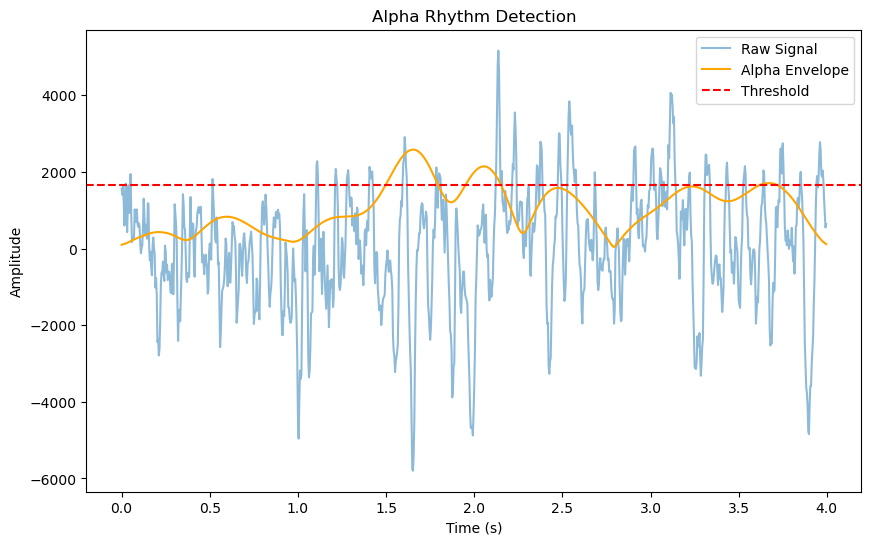

Proportion of time in genuine alpha rhythm in epoch 11: 16.80%


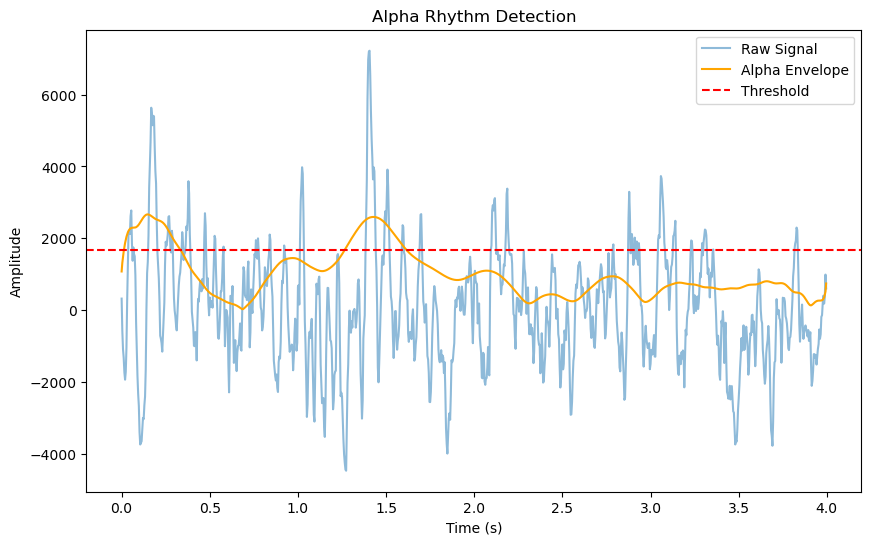

Proportion of time in genuine alpha rhythm in epoch 12: 17.29%


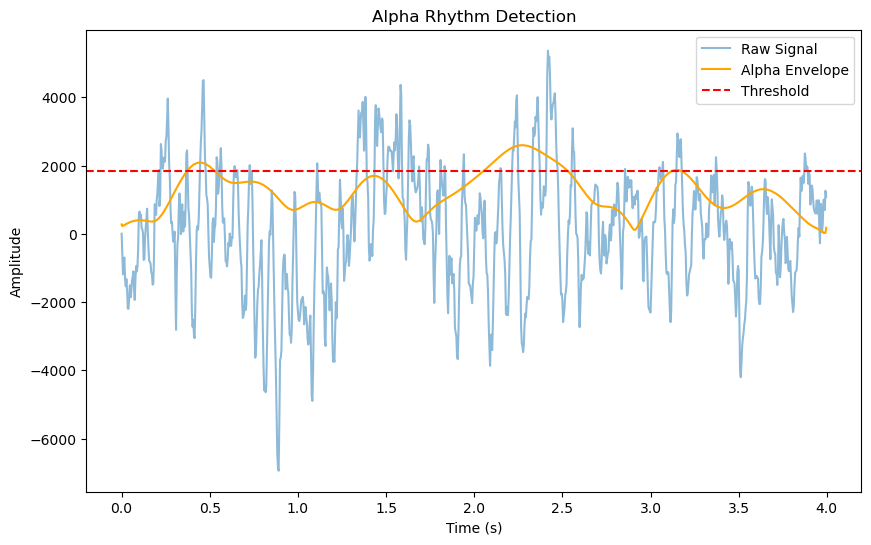

Proportion of time in genuine alpha rhythm in epoch 13: 17.09%


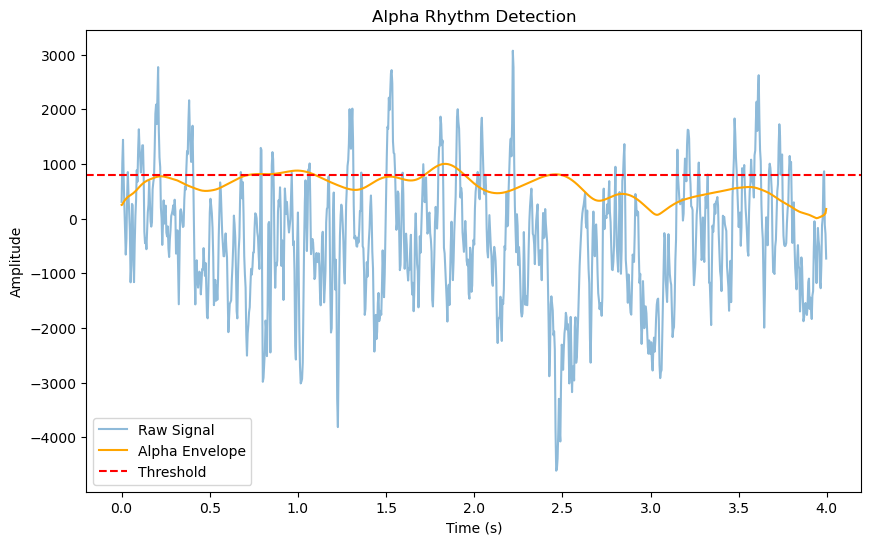

Proportion of time in genuine alpha rhythm in epoch 14: 16.41%


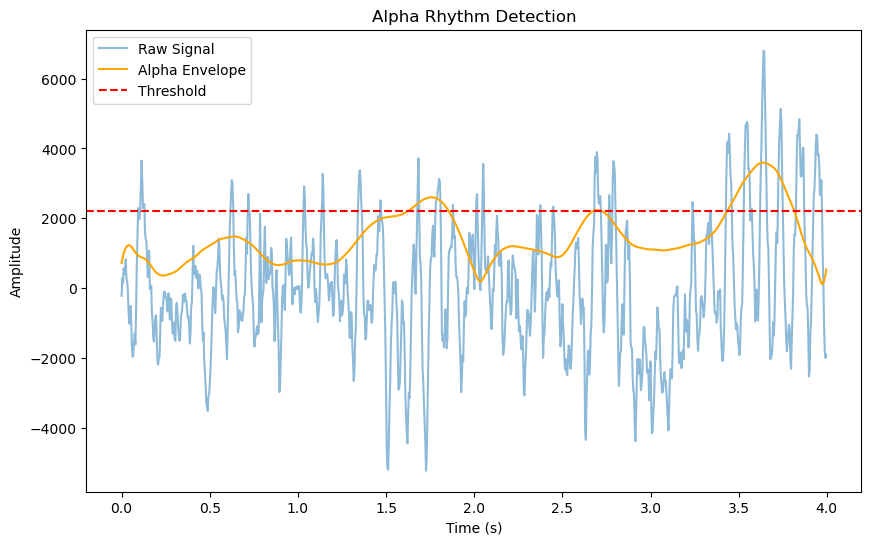


Summary of Alpha Rhythm Time Proportions:
       epoch_idx  alpha_time_proportion  alpha_threshold
count  15.000000              15.000000        15.000000
mean    7.000000               0.173112      1753.753335
std     4.472136               0.038832       517.050576
min     0.000000               0.099609       798.527789
25%     3.500000               0.150879      1489.927287
50%     7.000000               0.170898      1662.795079
75%    10.500000               0.201660      2058.567611
max    14.000000               0.249023      2869.785196


In [31]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt

# Band-pass filter function
def bandpass_filter(data, sfreq, low_freq, high_freq):
    nyquist = 0.5 * sfreq
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data)

# Identify time in genuine alpha rhythm
def time_in_alpha(epoch_data, sfreq, alpha_range=(8, 12), threshold_factor=1):
    """
    Calculate the proportion of time spent in genuine alpha rhythm.

    Parameters:
    - epoch_data: 1D array of EEG data for a single epoch (time samples).
    - sfreq: Sampling frequency of the EEG data.
    - alpha_range: Tuple specifying the alpha band (default: 8–12 Hz).
    - threshold_factor: Factor for defining the threshold for genuine alpha (e.g., mean + 2*std).

    Returns:
    - alpha_time: Proportion of epoch time spent in genuine alpha rhythm.
    - threshold: Threshold value for genuine alpha detection.
    - alpha_envelope: Instantaneous power of the alpha rhythm.
    """
    # Band-pass filter to isolate alpha activity
    alpha_band = bandpass_filter(epoch_data, sfreq, alpha_range[0], alpha_range[1])
    
    # Compute the amplitude envelope using the Hilbert transform
    alpha_envelope = np.abs(hilbert(alpha_band))
    
    # Define threshold for genuine alpha rhythm
    threshold = np.mean(alpha_envelope) + threshold_factor * np.std(alpha_envelope)
    
    # Identify time points where the envelope exceeds the threshold
    alpha_points = alpha_envelope > threshold
    
    # Calculate proportion of time in alpha rhythm
    alpha_time = np.sum(alpha_points) / len(alpha_points)
    
    return alpha_time, threshold, alpha_envelope

# Example usage
sfreq = epochs_rs.info['sfreq']  # Sampling frequency
alpha_results = []

for epoch_idx in range(len(epochs_rs)):
    epoch_data = epochs_rs.get_data()[epoch_idx].mean(axis=0)  # Average across channels
    alpha_time, threshold, alpha_envelope = time_in_alpha(epoch_data, sfreq)
    
    # Store the results for each epoch
    alpha_results.append({
        'epoch_idx': epoch_idx,
        'alpha_time_proportion': alpha_time,
        'alpha_threshold': threshold
    })

    # Print the result for the current epoch
    print(f"Proportion of time in genuine alpha rhythm in epoch {epoch_idx}: {alpha_time * 100:.2f}%")
    time = np.arange(len(epoch_data)) / sfreq  # Time vector in seconds

    plt.figure(figsize=(10, 6))
    plt.plot(time, epoch_data, label='Raw Signal', alpha=0.5)
    plt.plot(time, alpha_envelope, label='Alpha Envelope', color='orange')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
    plt.title("Alpha Rhythm Detection")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


alpha_df = pd.DataFrame(alpha_results)

# Display summary statistics
print("\nSummary of Alpha Rhythm Time Proportions:")
print(alpha_df.describe())



### visualizing alpha filter + hilbert envelope!

Visualizing Epoch 1/15


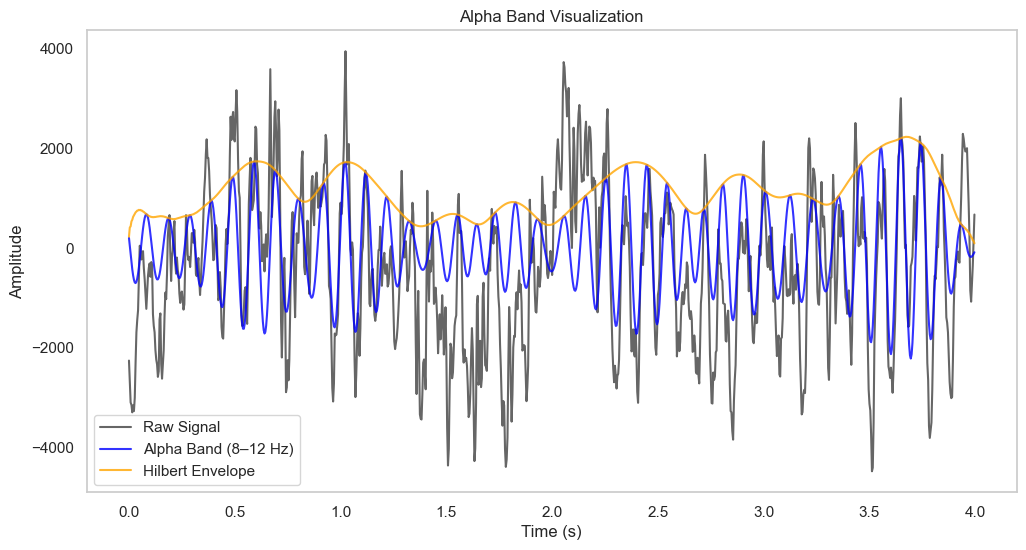

Visualizing Epoch 2/15


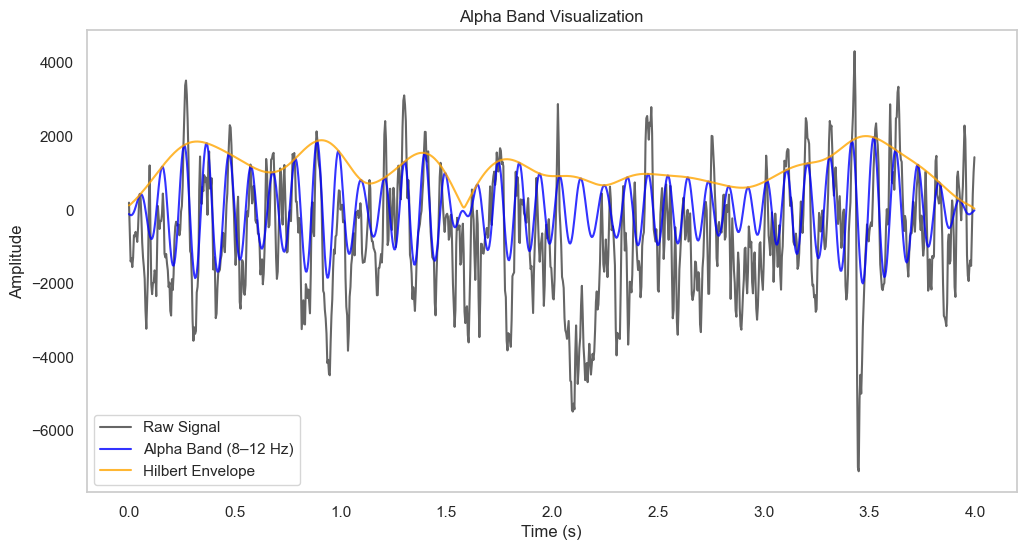

Visualizing Epoch 3/15


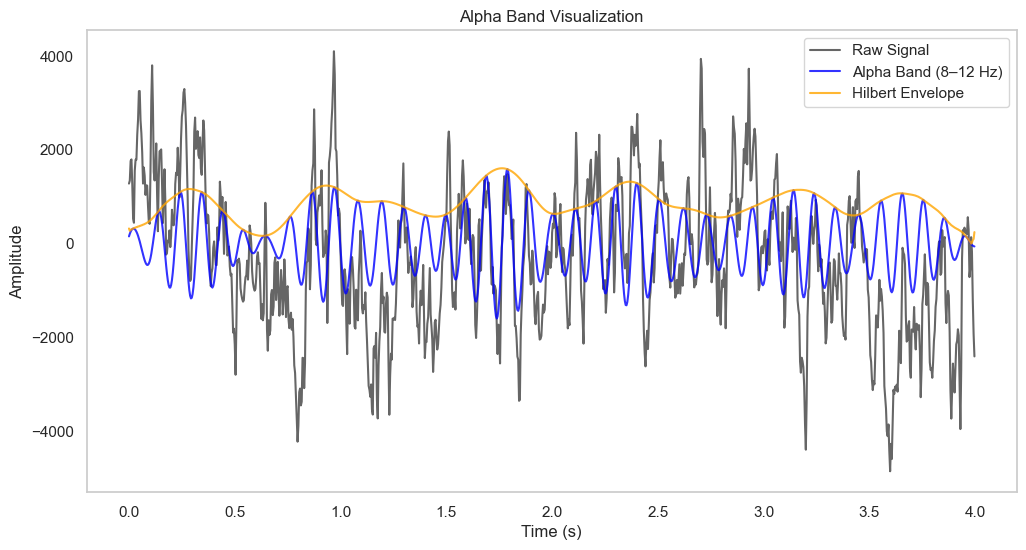

Visualizing Epoch 4/15


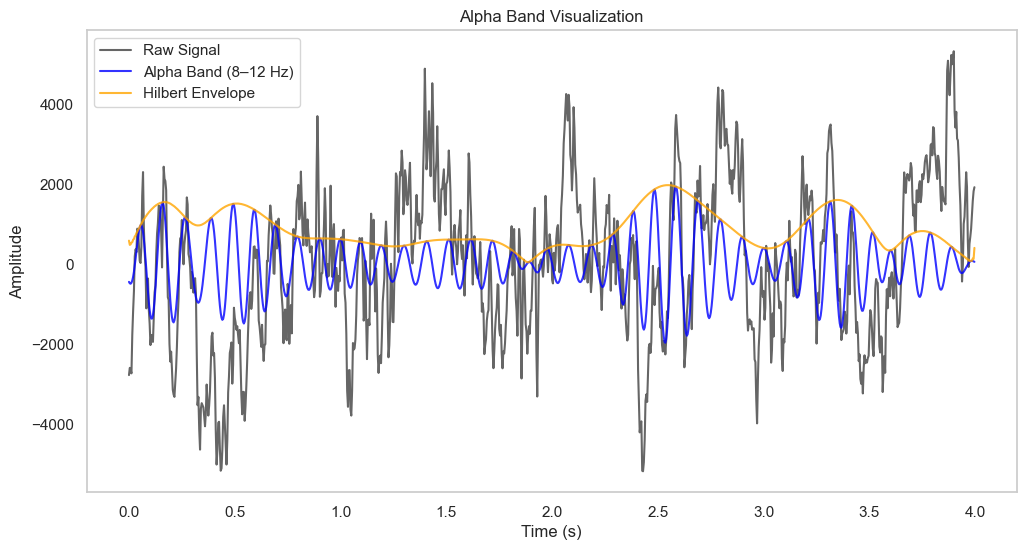

Visualizing Epoch 5/15


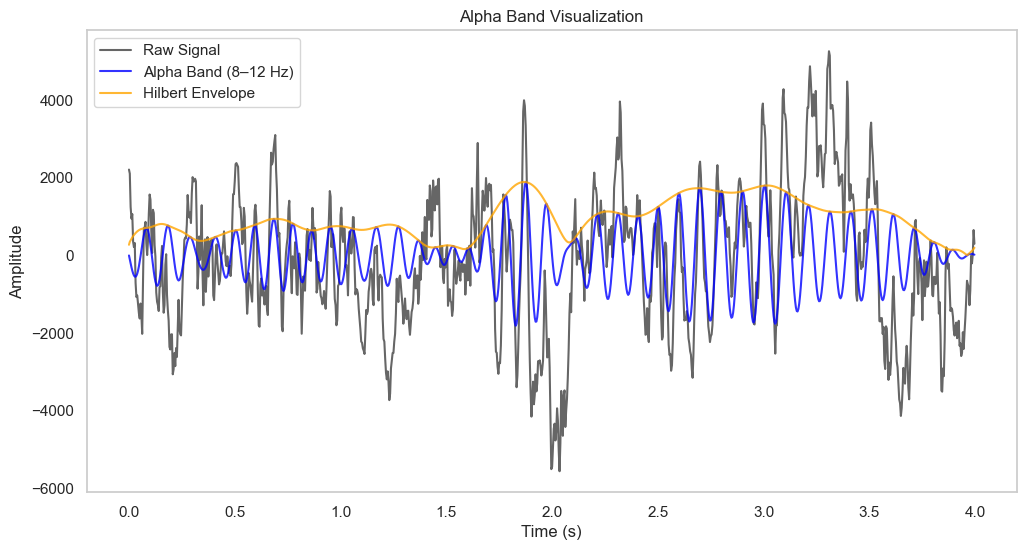

Visualizing Epoch 6/15


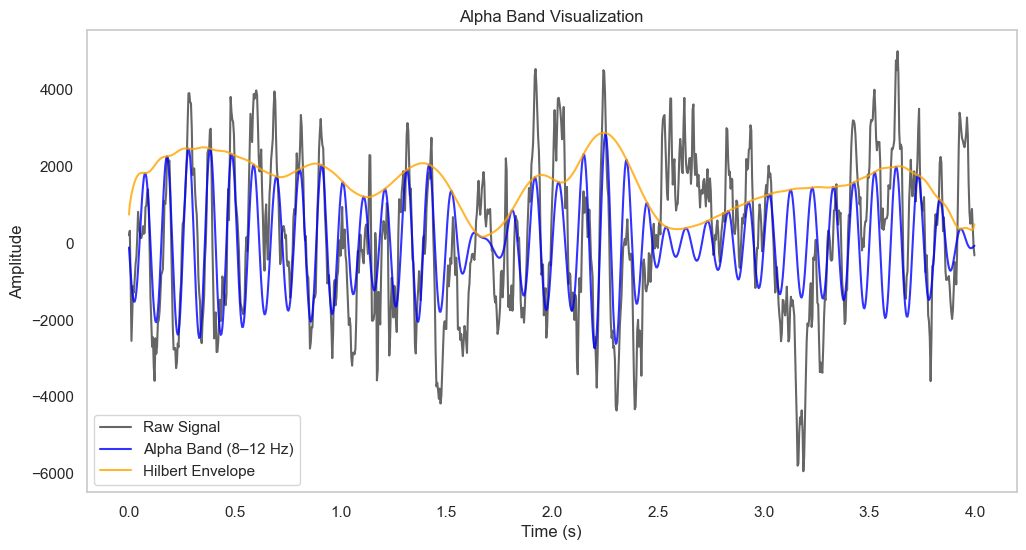

Visualizing Epoch 7/15


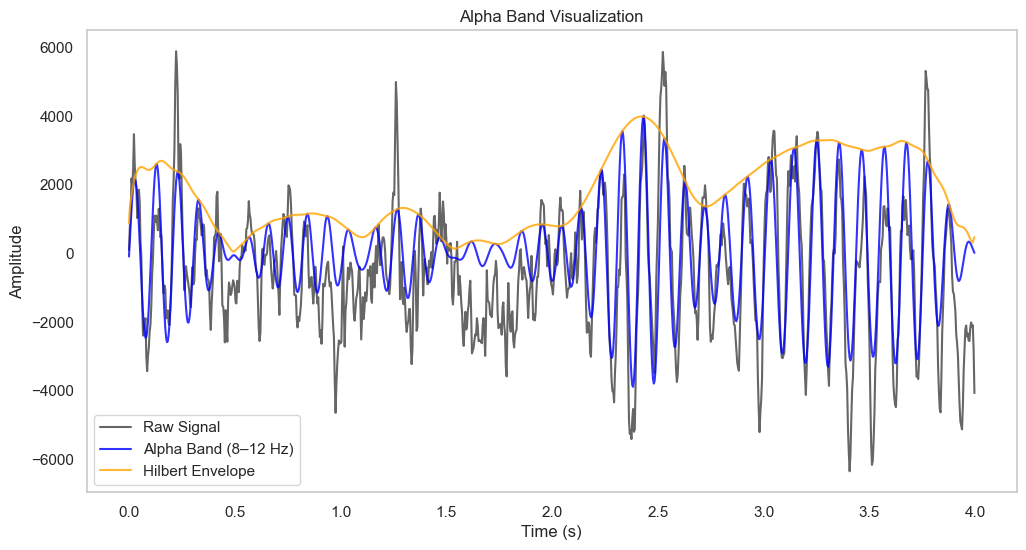

Visualizing Epoch 8/15


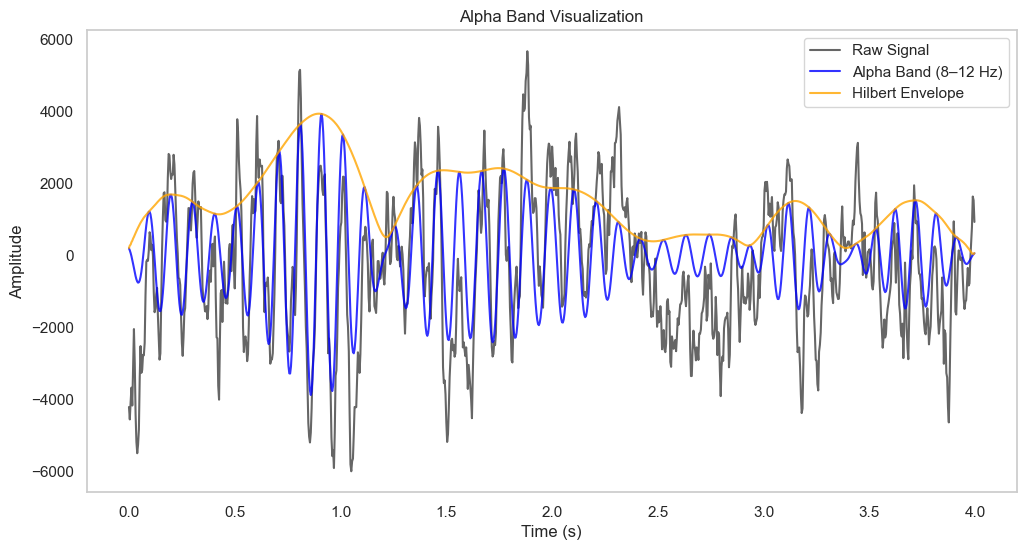

Visualizing Epoch 9/15


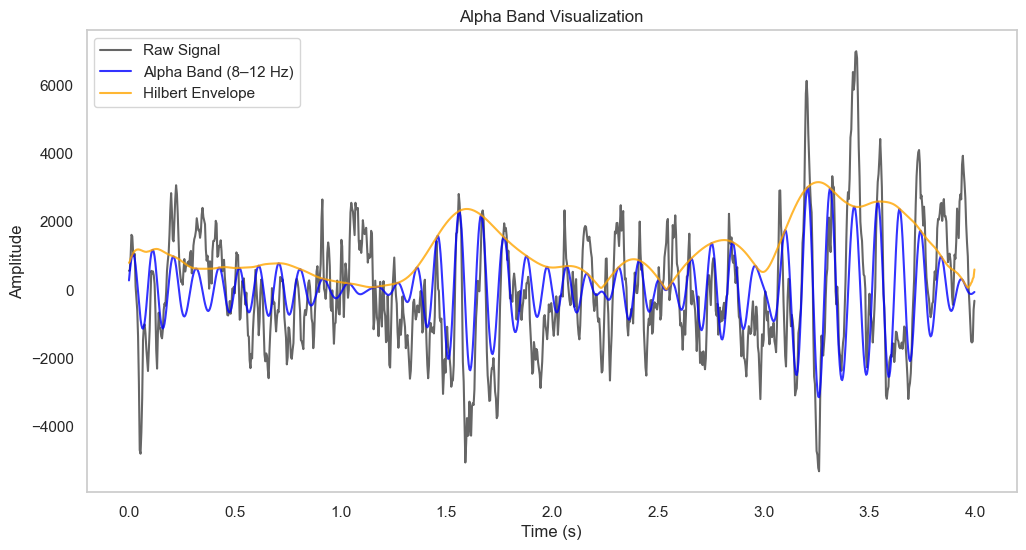

Visualizing Epoch 10/15


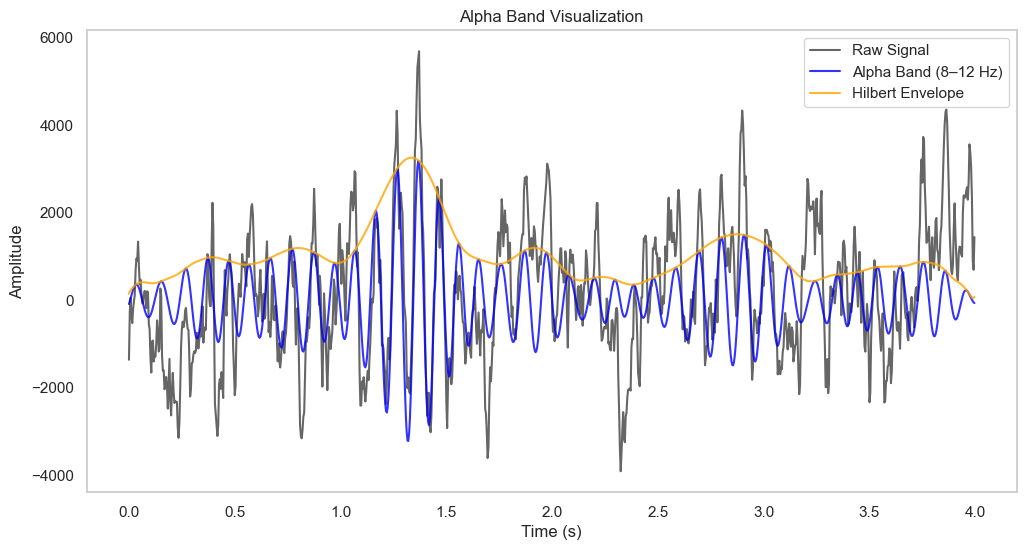

Visualizing Epoch 11/15


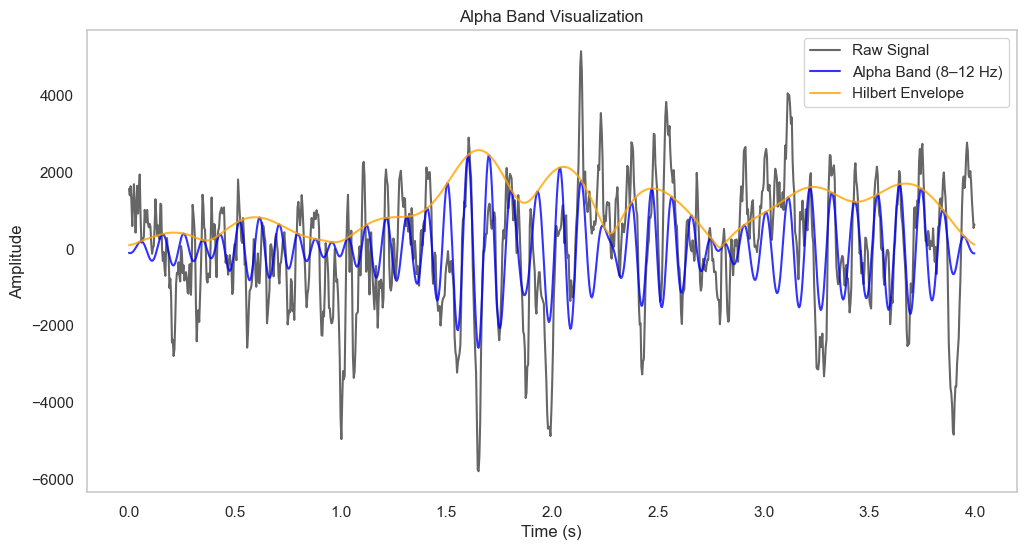

Visualizing Epoch 12/15


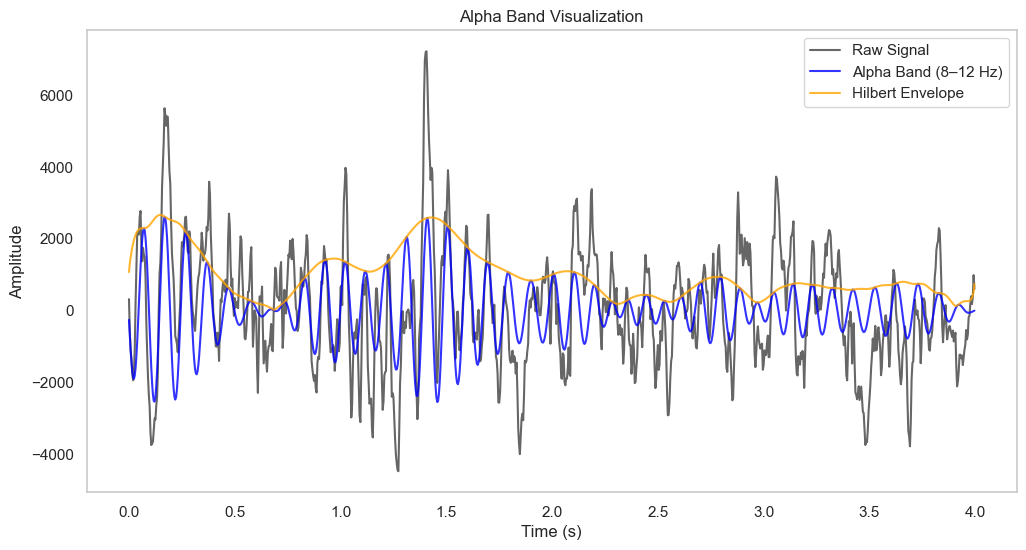

Visualizing Epoch 13/15


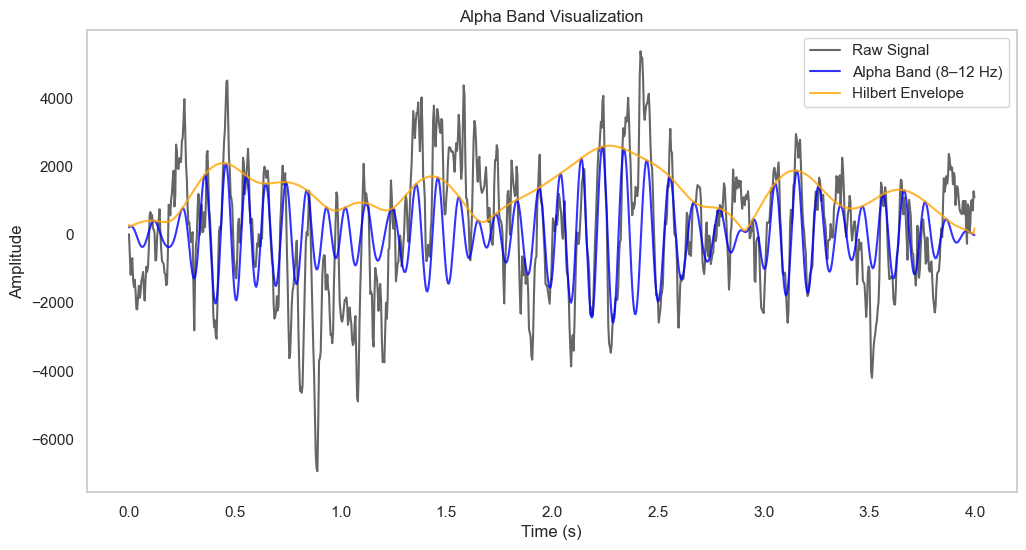

Visualizing Epoch 14/15


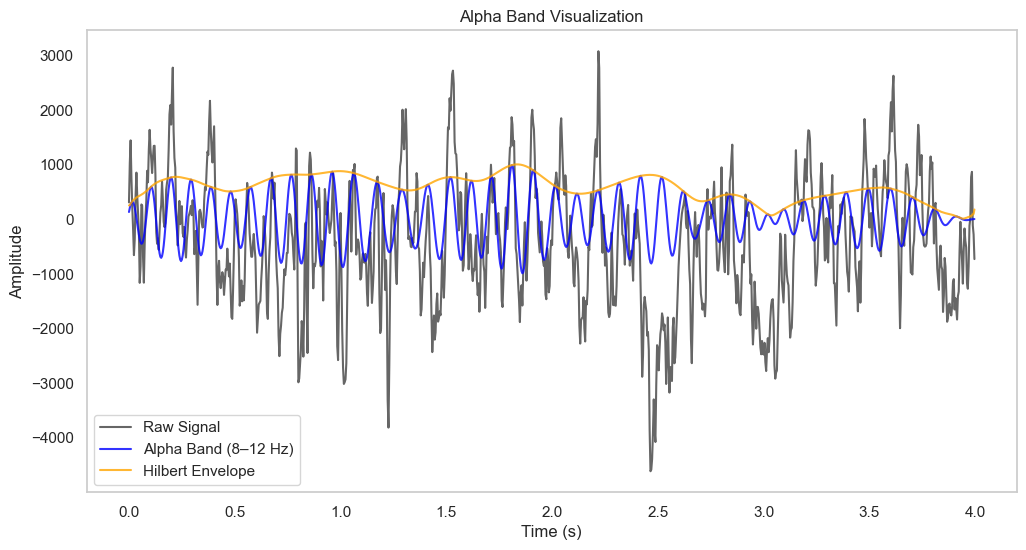

Visualizing Epoch 15/15


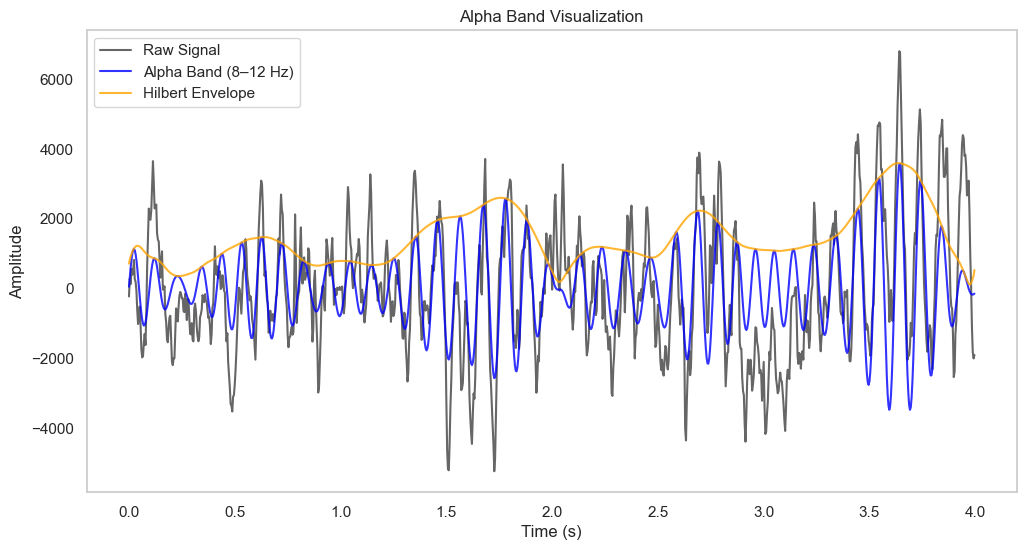

In [32]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, hilbert
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting styles
sns.set(rc={'figure.figsize': (12, 9)})
sns.set_style("whitegrid", {'axes.grid': False})

# Bandpass filter function
def butter_bandpass(data, fs, filt_freq, order=4):
    """
    Apply a Butterworth bandpass filter to the data.

    Parameters:
    - data: 1D array, signal to be filtered.
    - fs: Sampling frequency in Hz.
    - filt_freq: Tuple, (low, high) cutoff frequencies.
    - order: Filter order (default: 4).

    Returns:
    - Filtered signal.
    """
    nyq = 0.5 * fs  # Nyquist frequency
    low, high = filt_freq[0] / nyq, filt_freq[1] / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sosfiltfilt(sos, data)

# Visualize raw signal, alpha band, and Hilbert envelope
def visualize_alpha(epoch_data, sfreq, alpha_range=(8, 12), segment=None):
    """
    Visualize the raw signal, alpha band-pass filtered signal, and Hilbert envelope.

    Parameters:
    - epoch_data: 1D array, EEG data for one epoch.
    - sfreq: Sampling frequency in Hz.
    - alpha_range: Tuple, (low, high) frequencies for alpha band (default: 8–12 Hz).
    - segment: Tuple, (start, end) indices for the time segment to visualize.
    """
    # Bandpass filter to isolate alpha band
    alpha_signal = butter_bandpass(epoch_data, sfreq, filt_freq=alpha_range, order=4)
    
    # Compute Hilbert transform to get amplitude envelope
    alpha_envelope = np.abs(hilbert(alpha_signal))

    # Time axis for plotting
    times = np.arange(len(epoch_data)) / sfreq

    # Determine segment for visualization
    if segment is None:
        segment = (0, len(epoch_data))  # Full epoch

    # Plot raw signal, alpha band, and envelope
    plt.figure(figsize=(12, 6))
    plt.plot(times[segment[0]:segment[1]], epoch_data[segment[0]:segment[1]], label='Raw Signal', color='black', alpha=0.6)
    plt.plot(times[segment[0]:segment[1]], alpha_signal[segment[0]:segment[1]], label='Alpha Band (8–12 Hz)', color='blue', alpha=0.8)
    plt.plot(times[segment[0]:segment[1]], alpha_envelope[segment[0]:segment[1]], label='Hilbert Envelope', color='orange', alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Alpha Band Visualization')
    plt.legend()
    plt.show()

# Example usage: Iterate through all epochs
sfreq = epochs_rs.info['sfreq']  # Sampling frequency
for epoch_idx in range(len(epochs_rs)):
    epoch_data = epochs_rs.get_data()[epoch_idx].mean(axis=0)  # Average across channels
    print(f"Visualizing Epoch {epoch_idx + 1}/{len(epochs_rs)}")
    visualize_alpha(epoch_data, sfreq, segment=(0, int(sfreq * 4)))  # Full 4-second epoch


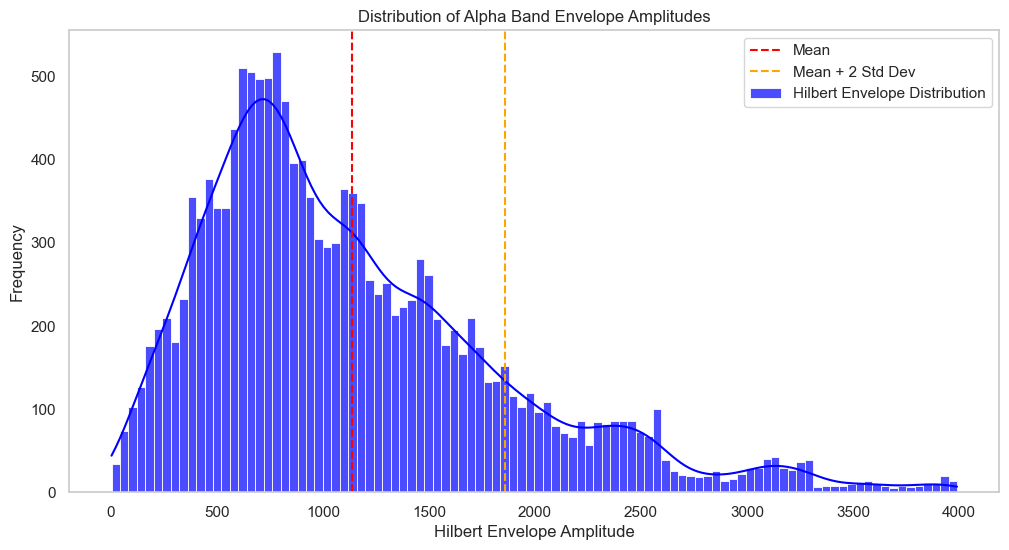

Chosen Threshold for Genuine Alpha Activity: 2575.50


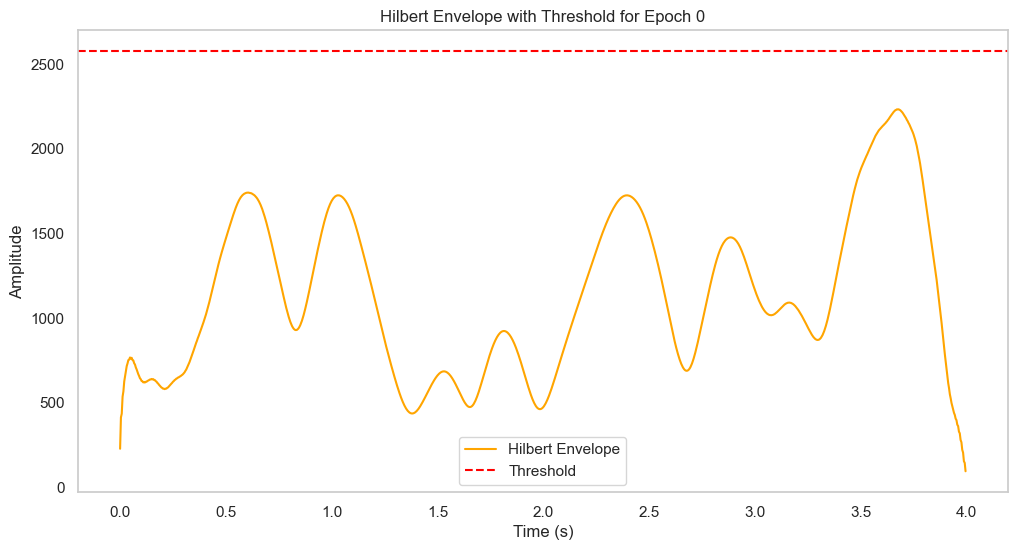

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert

alpha_range=(8, 12)

# Collect Hilbert envelope values across all epochs
def collect_alpha_envelopes(epochs, sfreq, alpha_range):
    """
    Collect Hilbert envelope values for the alpha band across all epochs.

    Parameters:
    - epochs: MNE Epochs object.
    - sfreq: Sampling frequency.
    - alpha_range: Tuple, (low, high) frequencies for alpha band (default: 8–12 Hz).

    Returns:
    - envelopes: List of Hilbert envelope values from all epochs.
    """
    envelopes = []
    for epoch_idx in range(len(epochs)):
        epoch_data = epochs.get_data()[epoch_idx].mean(axis=0)  # Average across channels
        alpha_signal = butter_bandpass(epoch_data, sfreq, alpha_range)  # Bandpass filter
        alpha_envelope = np.abs(hilbert(alpha_signal))  # Compute Hilbert envelope
        envelopes.extend(alpha_envelope)  # Append envelope values
    return np.array(envelopes)

# Collect alpha envelopes from epochs
sfreq = epochs_rs.info['sfreq']  # Sampling frequency
alpha_envelopes = collect_alpha_envelopes(epochs_rs, sfreq, alpha_range)

# Visualize the distribution of envelope values
plt.figure(figsize=(12, 6))
sns.histplot(alpha_envelopes, bins=100, kde=True, color='blue', alpha=0.7, label='Hilbert Envelope Distribution')
plt.xlabel('Hilbert Envelope Amplitude')
plt.ylabel('Frequency')
plt.title('Distribution of Alpha Band Envelope Amplitudes')
plt.axvline(x=np.mean(alpha_envelopes), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.mean(alpha_envelopes) + np.std(alpha_envelopes), color='orange', linestyle='--', label='Mean + 2 Std Dev')
plt.legend()
plt.show()

# Determine threshold (e.g., Mean + 2*Std Dev)
threshold = np.mean(alpha_envelopes) + np.std(alpha_envelopes)
print(f"Chosen Threshold for Genuine Alpha Activity: {threshold:.2f}")

# Visualize example epoch with threshold
epoch_idx = 0
epoch_data = epochs_rs.get_data()[epoch_idx].mean(axis=0)
alpha_signal = butter_bandpass(epoch_data, sfreq, alpha_range)
alpha_envelope = np.abs(hilbert(alpha_signal))

time = np.arange(len(epoch_data)) / sfreq
plt.figure(figsize=(12, 6))
plt.plot(time, alpha_envelope, label='Hilbert Envelope', color='orange')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Hilbert Envelope with Threshold for Epoch {epoch_idx}')
plt.legend()
plt.show()
